In [1]:
import os
import time
import math 
from tqdm import tqdm
import numpy as np
from PIL import Image
from skimage.color import hsv2rgb
import matplotlib.pyplot as plt
import keras
from keras import models, layers, initializers
from keras.layers import Input
import tensorflow as tf

keras.backend.set_learning_phase(1)


Using TensorFlow backend.


In [2]:
def build_model(n, variance, bw = False, width = 32, depth = 8, activation=tf.tanh):
    """Builds and returns CPPN."""
    input_shape=(n,)
    init = (initializers.VarianceScaling(scale=variance))

    densenet = True

    input = x = layers.Input(shape=input_shape)

    for _ in range(0, depth):
        x = layers.Dense(width, kernel_initializer=init, activation=activation)(x)

        # if densenet:
        #     x = layers.concatenate([x, y])
        # else:
        #     x = y

    x = layers.Dense(1 if bw else 3, activation='tanh')(x)

    model = models.Model(inputs=input, outputs=x)
    model.compile(optimizer='rmsprop', loss='mse')

    return model


def create_grid(size, lat, scale = 1.0):
    x_dim, y_dim = size
    N = np.mean((x_dim, y_dim))
    x = np.linspace(- x_dim / N * scale, x_dim / N * scale, x_dim)
    y = np.linspace(- y_dim / N * scale, y_dim / N * scale, y_dim)

    X, Y = np.meshgrid(x, y)

    x = np.ravel(X).reshape(-1, 1)
    y = np.ravel(Y).reshape(-1, 1)
    r = np.sqrt(x ** 2 + y ** 2)

    # lat = np.random.normal(0,1,1)
    Z = np.repeat(lat, x.shape[0]).reshape(-1, x.shape[0])

   #  h = x * y * x

    return x, y, Z.T, r # r, Z.T, alpha


def create_image(model, params, size):
    x_dim, y_dim = size
    X = np.concatenate(np.array(params), axis=1)
    pred = model.predict((X))

    img = []
    channels = pred.shape[1]
    for channel in range(channels):
        yp = pred[:, channel]
        yp = (yp - yp.min()) / (yp.max()-yp.min())
        img.append(yp.reshape(y_dim, x_dim))
    img = np.dstack(img)

    if channels == 3: img = hsv2rgb(img)
    img = (img * 255).astype(np.uint8)

    return img


def plot_images(images):
    """Plots the given images with pyplot (max 9)."""
    n = min(len(images), 9)
    rows = int(math.sqrt(n))
    cols = n // rows
    fig = plt.figure()
    for i in range(1, n+1):
        image = images[i-1]
        fig.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.imshow(image)
    plt.show()


def save_image(image, results_dir, postfix = ""):
    """Saves given image-array under the given path."""
    if not os.path.exists(results_dir): os.makedirs(results_dir)

    timestr = time.strftime("%Y%m%d-%H%M%S")
    image_name = f"img.{timestr}{postfix}.png"
    image_path = os.path.join(results_dir, image_name)
    file = Image.fromarray(image)
    file.save(image_path)    
    
    return image_path

In [3]:
path="/home/niladri/Projects/Pattern"

In [4]:
width=32
depth=8
x=1920
y=1080

100%|██████████| 1/1 [00:35<00:00, 35.64s/it]

Image saved under /home/niladri/Projects/Pattern


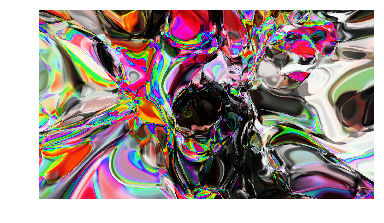

In [41]:
params = create_grid((x, y), 1.0)
images = []
seed=56
#tf.set_random_seed(seed)
#np.random.seed(seed)
variance = np.random.uniform(50,150)
lat = np.random.normal(0,1,1)
bw=False
model = build_model(len(params), variance, bw, width, depth)
for j in tqdm(range(1)):
    params = create_grid((x,y), lat + 2 * j / 1, 1.0)
    image = create_image(model, params, (x, y))
    image = image.squeeze()
    images.append(image)
    image_path = save_image(image,path, f'.var{variance:.0f}.seed{seed}.width{width}.depth{depth}')
    tqdm.write(f"Image saved under {path}")
plot_images(images)